In [285]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics_new import a_grav, da_grav_dp_vec, d2a_grav_dp_vec_dp_vecT, a_J2, da_J2_dp_vec, d2a_J2_dp_vec_dp_vecT, a_drag, da_drag_dp_vec, da_drag_dv_vec, d2a_drag_dp_vec_dp_vecT, d2a_drag_dp_vec_dv_vecT, d2a_drag_dv_vec_dp_vecT, d2a_drag_dv_vec_dv_vecT
from utils import get_form_initial_conditions

In [286]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 15 # Window size [min]
invalid_rmse = 1e20 # [m]

In [287]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [288]:
def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i)))# + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i)# + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        # first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))# + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        # aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        # aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            # second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i) + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i) + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i) + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)
    k4 = diff_eq(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = Ddiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = Hdiff_eq(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ Hdiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(Ddiff_eq(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ Hdiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(Ddiff_eq(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ Hdiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(Ddiff_eq(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [289]:
def h(x_vec):
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [290]:
def J_tau(tau, dt, y, x_vec):
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def DJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def HJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

In [291]:
def J(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    J_x = 0
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        J_x += 1 / 2 * (y - h_x).T @ R_inv @ (y - h_x)
        x_vec = f(dt, x_vec)
    return J_x

def DJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DJ_x = np.zeros((n, 1))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        DJ_x += -STM.T @ Dh(x_vec).T @ R_inv @ (y - h(x_vec))
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return DJ_x

def HJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    HJ_x = np.zeros((n, n))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        Dh_x = Dh(x_vec)
        Hh_x = Hh(x_vec)
        Df_x = STM
        Hf_x = DSTM
        HJ_x += - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return HJ_x

In [292]:
class CentralizedNewton:
    def __init__(self, tolerance=1e-6, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.iterations = None
        
        # Storage for results
        self.cost_values = []
        self.gradient_norm_values = []

    def solve(self, k, dt, Y, x_init, x_true_initial, x_true_end):
        x = x_init.copy()

        prev_cost_value = None
        prev_gradient_norm_value = None
        prev_global_estimation_error = None
        grad_norm_order_history = []

        for iteration in range(self.max_iter + 1):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            J_x = J(k, dt, Y, x)
            DJ_x = DJ(k, dt, Y, x)
            HJ_x = HJ(k, dt, Y, x)

            # Convergence tracking
            cost_value = J_x[0][0]
            gradient_norm_value = np.linalg.norm(DJ_x)

            # Store the values
            self.cost_values.append(cost_value)
            self.gradient_norm_values.append(gradient_norm_value)

            # Metrics
            if prev_cost_value is not None:
                cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
                gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
                global_estimation_error_change = (np.linalg.norm(x - x_true_initial) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
            prev_cost_value = cost_value
            prev_gradient_norm_value = gradient_norm_value
            prev_global_estimation_error = np.linalg.norm(x - x_true_initial)
            
            # Track gradient norm order of magnitude
            current_order = int(np.floor(np.log10(gradient_norm_value + 1e-12)))  # avoid log(0)
            grad_norm_order_history.append(current_order)

            if len(grad_norm_order_history) >= 3:
                if grad_norm_order_history[-1] == grad_norm_order_history[-2] == grad_norm_order_history[-3]:
                    stagnant_order = True
                else:
                    stagnant_order = False
            else:
                stagnant_order = False
            
            # Propagate window initial conditions for metrics 
            x_end = x.copy()
            for _ in range(H - 1):
                x_end = f(dt, x_end)

            # Check convergence and print metrics
            if gradient_norm_value < self.grad_tol or iteration == self.max_iter or stagnant_order:
                reason = "tolerance reached" if gradient_norm_value < self.grad_tol else \
                        "max iteration reached" if iteration == self.max_iter else \
                        "gradient norm stagnated"
                print(f"STOP on Iteration {iteration} ({reason})")
                print(f"Cost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                print(f"Final initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
                print(f"Final position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true_initial)} ({global_estimation_error_change:.2f}%)")
                    
            # Print estimation errors 
            print(f"Initial conditions estimation errors: {np.linalg.norm(x[:n_p, :] - x_true_initial[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true_initial[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true_initial[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true_initial[3 * n_x : 3 * n_x + n_p, :])} m")
            print(f"Position estimation errors: {np.linalg.norm(x_end[:n_p, :] - x_true_end[:n_p, :])} m, {np.linalg.norm(x_end[n_x : n_x + n_p, :] - x_true_end[n_x : n_x + n_p, :])} m, {np.linalg.norm(x_end[2 * n_x : 2 * n_x + n_p, :] - x_true_end[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x_end[3 * n_x : 3 * n_x + n_p, :] - x_true_end[3 * n_x : 3 * n_x + n_p, :])} m\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(HJ_x, -DJ_x)
            x += delta_x
        
            # Save the current iteration
            self.iterations = iteration + 1
            
        # Propagate window initial conditions getting estimate at timestamp k
        x_init = x
        for _ in range(H - 1):
            x = f(dt, x)

        return x_init, x

In [293]:
def plots(algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function')
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

In [294]:
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((n, 1, K))
X_true[:, :, 0] = X_initial
for k in range(K - 1):
    X_true[:, :, k + 1] = f(dt, X_true[:, :, k])

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = f(dt, X_est[:, :, k])
position_estimation_error_1_initial = np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_2_initial = np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_3_initial = np.linalg.norm(X_est[2 * n_x:2 * n_x + n_p, :, :] - X_true[2 * n_x:2 * n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_4_initial = np.linalg.norm(X_est[3 * n_x:3 * n_x + n_p, :, :] - X_true[3 * n_x:3 * n_x + n_p, :, :], axis=0).reshape(-1, 1)

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------


Before applying the algorithm
Cost function: 51811733.278387636
Gradient norm: 151464008.86101583
Global estimation error: 429.5049051955781
Initial conditions estimation errors: 272.4697073631671 m, 173.20827048054102 m, 227.77973283442685 m, 168.3746081659556 m
Position estimation errors: 216.8637149626735 m, 277.7490400468229 m, 378.79086449351837 m, 293.70894029132745 m

Iteration 1
Cost function: 32613.667927677347 (-99.94%)
Gradient norm: 301161.3915913899 (-99.80%)
Global estimation error: 460.23887637625097 (7.16%)
Initial conditions estimation errors: 0.0521530337642179 m, 233.0374321252035 m, 300.9017088142735 m, 258.78820138065436 m
Position estimation errors: 0.08149608412514478 m, 82.26082760424198 m, 139.5141277084508 m, 292.34544757027544 m

Iteration 2
Cost function: 32711.28863334523 (0.30%)
Gradient norm: 212333.34436776146 (-29.50%)
Global estimation error: 428.57587704065895 (-6.88%)
Initial conditions estimation errors: 0.05896823841215673 m, 162.38492033829144 m, 

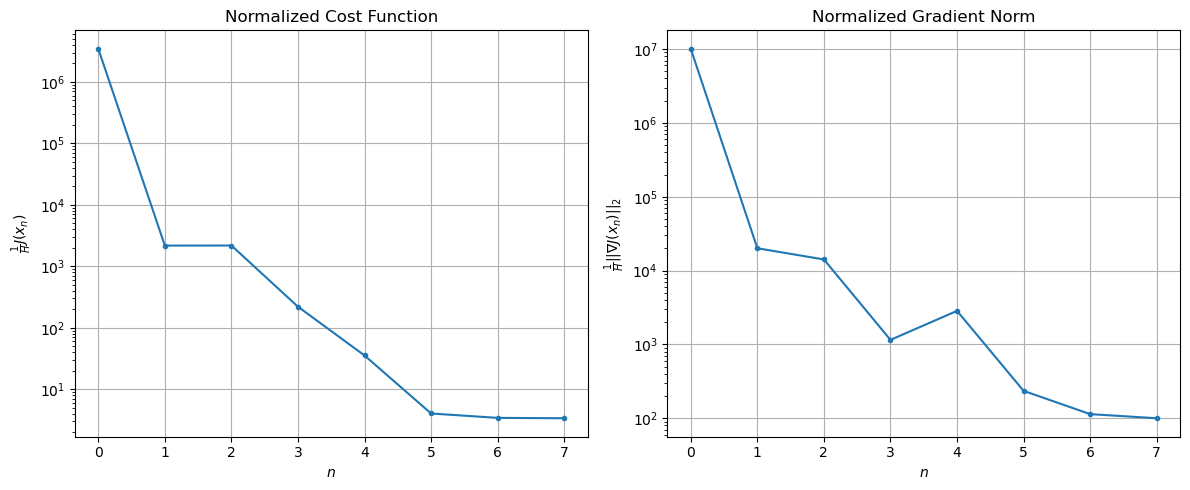

Before applying the algorithm
Cost function: 55.03255776636482
Gradient norm: 18337.214861109635
Global estimation error: 27.85108468223423
Initial conditions estimation errors: 0.05207687535076626 m, 13.967862377504742 m, 15.92394282225235 m, 18.08300110104204 m
Position estimation errors: 0.08627135788596943 m, 0.5453556928066253 m, 62.63173281487004 m, 69.19505515038095 m

Iteration 1
Cost function: 50.45543744533524 (-8.32%)
Gradient norm: 840.3256961432945 (-95.42%)
Global estimation error: 26.525807185574784 (-4.76%)
Initial conditions estimation errors: 0.03609897325588294 m, 9.23889667772795 m, 15.352901627858191 m, 19.55873277497884 m
Position estimation errors: 0.06920477861934862 m, 0.40001930966451665 m, 40.693146717651445 m, 45.11273087016077 m

Iteration 2
Cost function: 50.37469966500409 (-0.16%)
Gradient norm: 164.00470400885186 (-80.48%)
Global estimation error: 23.653095820629492 (-10.83%)
Initial conditions estimation errors: 0.036098972068065935 m, 7.363956621154141

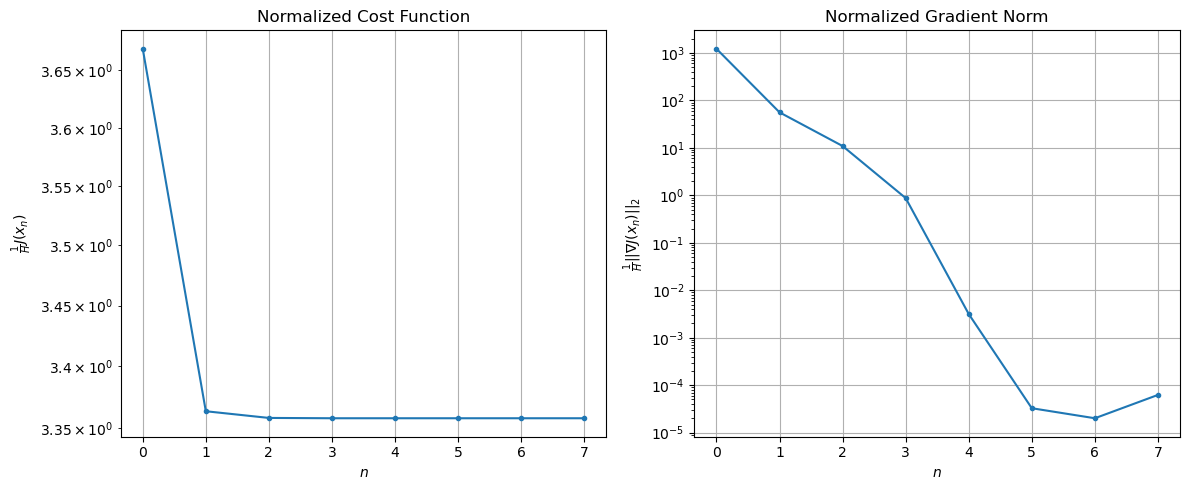

Before applying the algorithm
Cost function: 52.050770482032334
Gradient norm: 10528.439277383522
Global estimation error: 24.489228645786035
Initial conditions estimation errors: 0.03768604356805147 m, 6.401937108453322 m, 14.626010943959662 m, 18.56916706683646 m
Position estimation errors: 0.0748400528479697 m, 1.28567618546468 m, 29.640436638103274 m, 32.64176261853231 m

Iteration 1
Cost function: 47.83182492013718 (-8.11%)
Gradient norm: 334.1262744498699 (-96.83%)
Global estimation error: 16.991592261878 (-30.62%)
Initial conditions estimation errors: 0.07032300020031142 m, 3.4184921200086045 m, 8.008867456758368 m, 14.59040414324328 m
Position estimation errors: 0.06134443741211901 m, 0.3800731496500778 m, 23.49772418679693 m, 20.43751162568054 m

Iteration 2
Cost function: 47.817465862350836 (-0.03%)
Gradient norm: 22.787348820802514 (-93.18%)
Global estimation error: 16.579879886189577 (-2.42%)
Initial conditions estimation errors: 0.07032299117975571 m, 3.3600191254973586 m,

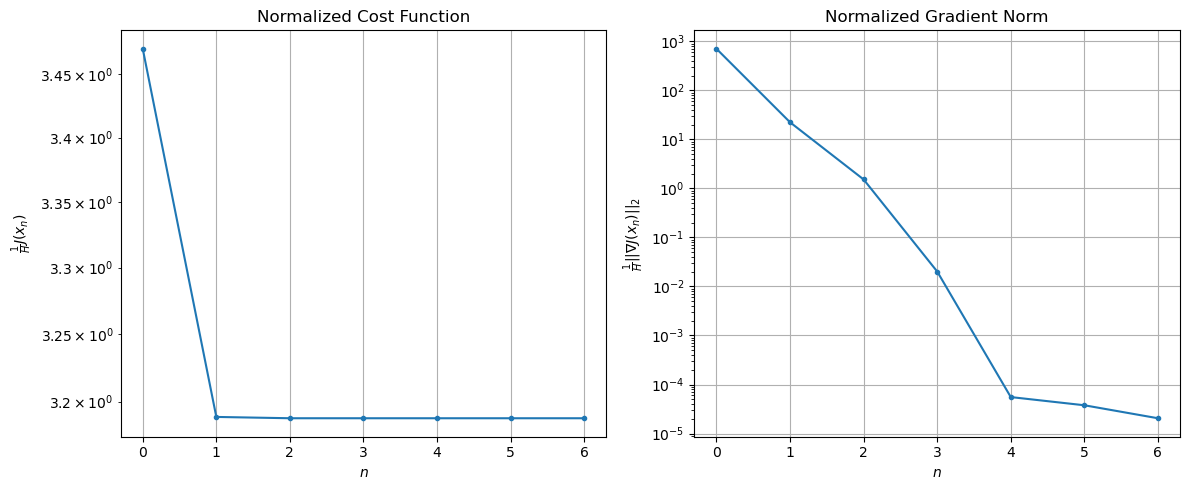

Before applying the algorithm
Cost function: 55.35371396031327
Gradient norm: 9278.564413348588
Global estimation error: 16.831087793542128
Initial conditions estimation errors: 0.06647723234253265 m, 3.054556075153985 m, 8.50417531988156 m, 14.199610065955007 m
Position estimation errors: 0.06796259759597878 m, 0.5350800147530529 m, 20.25284261325122 m, 15.96125439511299 m

Iteration 1
Cost function: 50.77293244478609 (-8.28%)
Gradient norm: 2365.0864001876052 (-74.51%)
Global estimation error: 5.555320503517249 (-66.99%)
Initial conditions estimation errors: 0.04661050213639722 m, 1.977079187625636 m, 3.5839561306941685 m, 3.7554966992567884 m
Position estimation errors: 0.0732885473863299 m, 1.2584728053306624 m, 19.611155867359727 m, 23.96290439640798 m

Iteration 2
Cost function: 50.51165437177135 (-0.51%)
Gradient norm: 123.00065189629771 (-94.80%)
Global estimation error: 6.932384663150339 (24.79%)
Initial conditions estimation errors: 0.04661050462894176 m, 1.9451393047665622 m

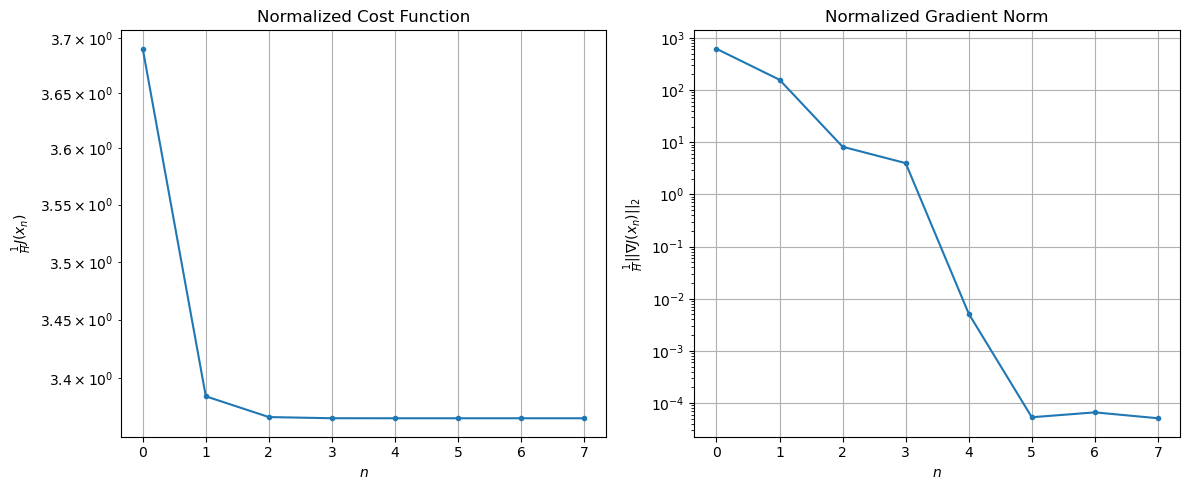

Before applying the algorithm
Cost function: 54.272108934816536
Gradient norm: 9138.364713593724
Global estimation error: 7.094803159278468
Initial conditions estimation errors: 0.04520451359882929 m, 2.0878390013676857 m, 4.799240584359444 m, 4.78977703524536 m
Position estimation errors: 0.08073504821599176 m, 1.763581565046678 m, 7.185708386249872 m, 9.11534049428478 m

Iteration 1
Cost function: 51.94415374203844 (-4.29%)
Gradient norm: 80.204024820486 (-99.12%)
Global estimation error: 10.949375603150964 (54.33%)
Initial conditions estimation errors: 0.03304892524588075 m, 3.296658202746205 m, 7.422602105135153 m, 7.343330572006191 m
Position estimation errors: 0.07543017108092498 m, 0.5788648724833896 m, 5.8805622690064805 m, 1.7164425156738226 m

Iteration 2
Cost function: 51.93913022979555 (-0.01%)
Gradient norm: 7.2310900196998915 (-90.98%)
Global estimation error: 10.907260289993994 (-0.38%)
Initial conditions estimation errors: 0.033048925322168014 m, 3.100498530274889 m, 7.

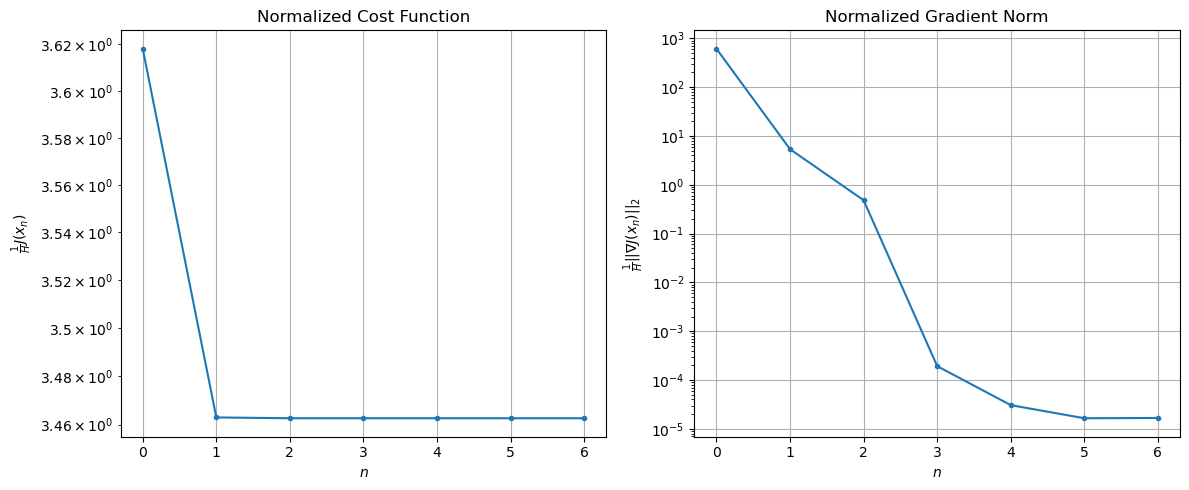

Before applying the algorithm
Cost function: 51.51119807169364
Gradient norm: 10912.395789144839
Global estimation error: 9.751277090965232
Initial conditions estimation errors: 0.03358439026550311 m, 2.8913587384254607 m, 6.566230337234209 m, 6.603826266760582 m
Position estimation errors: 0.08255308996481779 m, 0.757332121175347 m, 8.761882710856232 m, 4.660744693727432 m

Iteration 1
Cost function: 47.27766876195386 (-8.22%)
Gradient norm: 398.52773167492836 (-96.35%)
Global estimation error: 14.927829869985842 (53.09%)
Initial conditions estimation errors: 0.06575285532729414 m, 2.7367169885434603 m, 7.9847821483863095 m, 12.31214327338092 m
Position estimation errors: 0.09289575200576955 m, 0.7029150845816506 m, 10.254206843368049 m, 13.215960220351054 m

Iteration 2
Cost function: 47.25408397700362 (-0.05%)
Gradient norm: 3.3873435152499862 (-99.15%)
Global estimation error: 12.933769973183868 (-13.36%)
Initial conditions estimation errors: 0.06575285801415079 m, 2.28309814545799

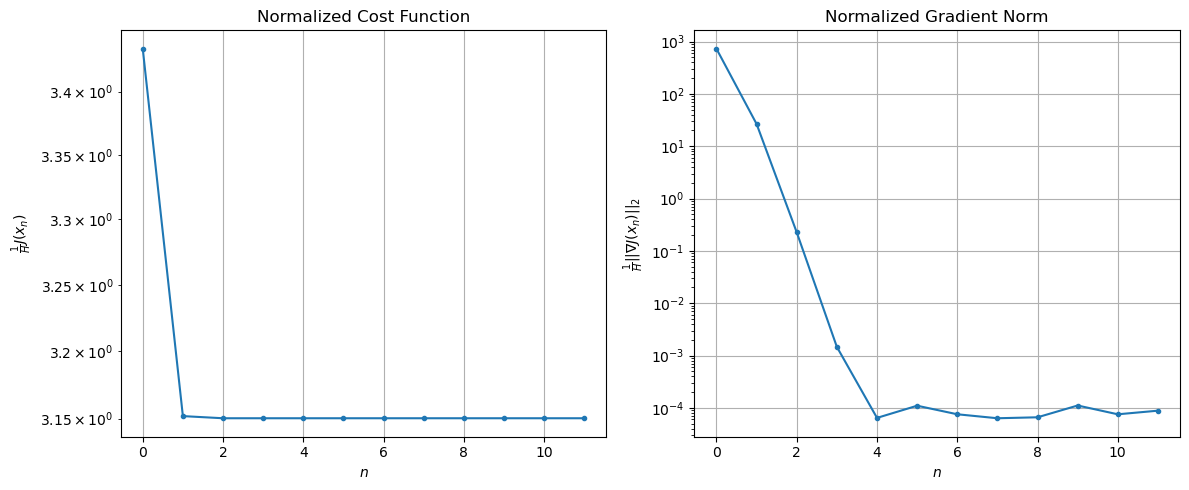

Before applying the algorithm
Cost function: 57.74400539973478
Gradient norm: 11283.22350619259
Global estimation error: 12.664439757539528
Initial conditions estimation errors: 0.06116347222098762 m, 2.1273738076556445 m, 6.842451392984939 m, 10.442164869006307 m
Position estimation errors: 0.10332297423156349 m, 0.8278014990147627 m, 11.97653825529678 m, 15.552307229457114 m

Iteration 1
Cost function: 547.9547103049181 (848.94%)
Gradient norm: 116969.98050180031 (936.67%)
Global estimation error: 63.12122342158819 (398.41%)
Initial conditions estimation errors: 0.09482637113560531 m, 29.470021045153707 m, 25.006297108343645 m, 49.90088511749778 m
Position estimation errors: 0.11999754208200226 m, 24.23764866088508 m, 307.11334009797696 m, 350.25453983993515 m

Iteration 2
Cost function: 86.04116665620533 (-84.30%)
Gradient norm: 244.05958943217863 (-99.79%)
Global estimation error: 69.63380536810396 (10.32%)
Initial conditions estimation errors: 0.09482665728447372 m, 30.16848823401

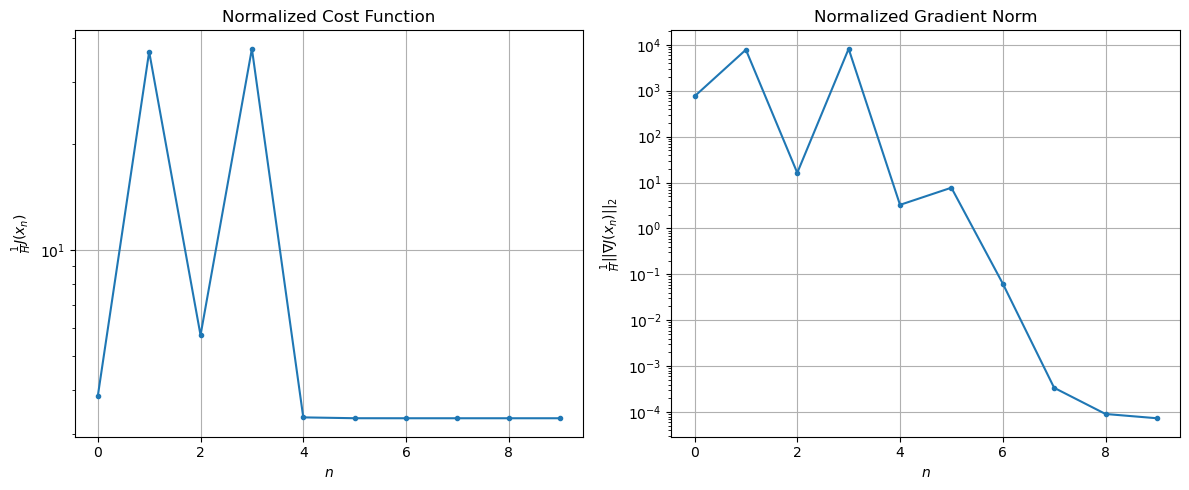

Before applying the algorithm
Cost function: 59.80390707309893
Gradient norm: 28969.26778750862
Global estimation error: 12.976637871014175
Initial conditions estimation errors: 0.08543896275035434 m, 3.1246459797326143 m, 11.159743890846748 m, 5.837911303487922 m
Position estimation errors: 0.133888811304503 m, 1.4949816882261608 m, 16.63443350331011 m, 13.419801575182698 m

Iteration 1
Cost function: 54.43740278319805 (-8.97%)
Gradient norm: 431.70948024190983 (-98.51%)
Global estimation error: 11.302805273275347 (-12.90%)
Initial conditions estimation errors: 0.11078867328986963 m, 1.7227066719707205 m, 7.749533045175746 m, 8.04475667747755 m
Position estimation errors: 0.12431791606001741 m, 1.8018550122724568 m, 2.318192129335902 m, 3.7942093112622897 m

Iteration 2
Cost function: 54.39771176370142 (-0.07%)
Gradient norm: 58.386255208083476 (-86.48%)
Global estimation error: 9.328103629274958 (-17.47%)
Initial conditions estimation errors: 0.11078865694694363 m, 2.3856552748805493

In [ ]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    
    # Observations
    Y = np.zeros((o, 1, K))
    for k in range(K):
        Y[:, :, k] = h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

    # Cold-start
    x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
    
    # Apply the algorithm
    X_est = np.zeros((n, 1, K))
    for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
        centralized_newton = CentralizedNewton()
        x_init, x_est = centralized_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
        X_est[:, :, k] = x_est
        
        plots(centralized_newton)

        if k == 0: # Check divergence in the beginning
            position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
            x_est_tau = x_est
            for tau in range(H):
                position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
                position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
                position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
                position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
                x_est_tau = f(dt, x_est_tau)
            rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
            rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
            rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
            rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
            if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
                print(f"This Monte Carlo run #{m + 1} diverged!")
            else:
                first_round_stop_iteration.append(centralized_newton.iterations)
        else:
            K_minus_H_next_rounds_stop_iteration.append(centralized_newton.iterations)

        # Warm-start
        x_init = f(dt, x_init)

    # After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
    position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
    rmse_1, rmse_2, rmse_3, rmse_4 = [], [], [], []
    for k in range(H - 1, K):
        position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
        position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
        position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
        position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
    rmse_m_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
    rmse_m_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
    rmse_m_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
    rmse_m_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
    print(f'This MC run RMSE for the {K - H + 1} timestamps:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > invalid_rmse or rmse_m_2 > invalid_rmse or rmse_m_3 > invalid_rmse or rmse_m_4 > invalid_rmse:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the {K - H + 1} timestamps for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of CentralizedNewton converged with {np.mean(first_round_stop_iteration)} iterations on average.')
print(f'The next {K - H} rounds of CentralizedNewton converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

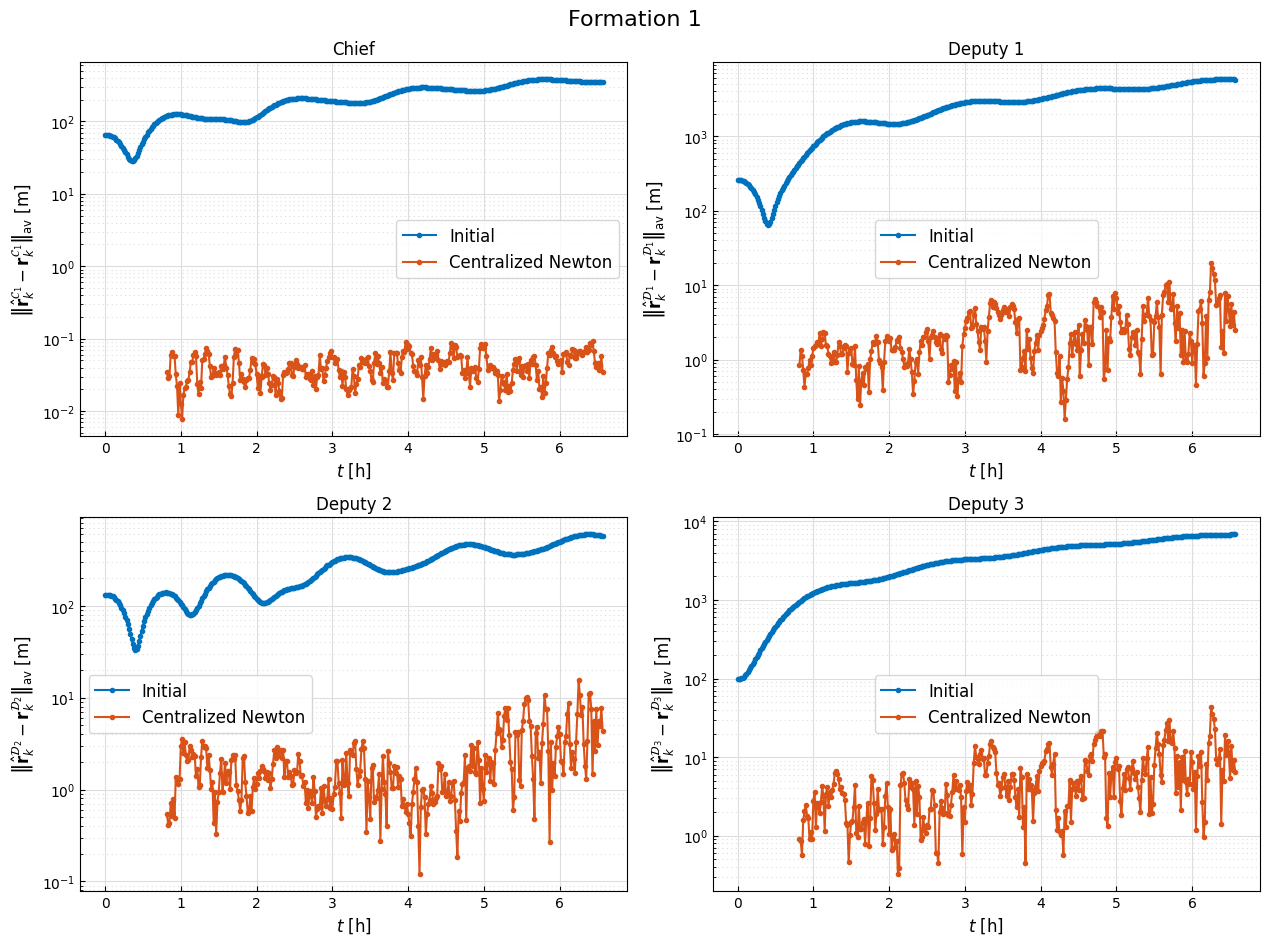

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()